1 Negative
3 Neutral
5 Positive

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import string 
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer,word_tokenize
import re
from nltk import FreqDist
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split,RandomizedSearchCV,GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from imblearn.pipeline import Pipeline  # Use imbalanced-learn's Pipeline
from imblearn.over_sampling import SMOTE

C:\Users\Gmwende\anaconda3\envs\learn-env\lib\site-packages\scipy\__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.4)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


In [2]:
# data =pd. read_csv('data\Apple-Twitter-Sentiment-DFE.csv',encoding='latin-1 ')
data =pd. read_csv(r'data\tweet_data_apple_google.csv',encoding='latin-1 ')
data

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion
...,...,...,...
9088,Ipad everywhere. #SXSW {link},iPad,Positive emotion
9089,"Wave, buzz... RT @mention We interrupt your re...",NaN,No emotion toward brand or product
9090,"Google's Zeiger, a physician never reported po...",NaN,No emotion toward brand or product
9091,Some Verizon iPhone customers complained their...,NaN,No emotion toward brand or product


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9093 entries, 0 to 9092
Data columns (total 3 columns):
 #   Column                                              Non-Null Count  Dtype 
---  ------                                              --------------  ----- 
 0   tweet_text                                          9092 non-null   object
 1   emotion_in_tweet_is_directed_at                     3291 non-null   object
 2   is_there_an_emotion_directed_at_a_brand_or_product  9093 non-null   object
dtypes: object(3)
memory usage: 213.2+ KB


In [4]:
data.describe()

,tweet_text,emotion_in_tweet_is_directed_at,is_there_an_emotion_directed_at_a_brand_or_product
count,9092,3291,9093
unique,9065,9,4
top,RT @mention Marissa Mayer: Google Will Connect...,iPad,No emotion toward brand or product
freq,5,946,5389


In [5]:
# data.describe(include='O')

In [6]:
#drop na
data.dropna(subset='tweet_text',inplace=True)

### preprocess text

In [7]:
def clean_text(text):
    stopword_list = stopwords.words('english')
    stopword_list += string.punctuation
    #lemmatize
    lemmatizer = WordNetLemmatizer()
    #remove link in text
#     text = re.sub(r"https?:[^\s]+","",text)
#     #remove usernames
#     text = re.sub('@[^\s]+','',text)
#      # Remove single-character words
#     text = re.sub(r'\b\w\b', '', text)
    #remove link,usernames,# and its value  and single characters at once
    text = re.sub(r"https?:[^\s]+|@[\S]+|\b\w\b", "", text)
    #remove hashags as well(\#\w+)
#     text =re.sub(r"https?:[^\s]+|@[\S]+|\b\w\b|\#\w+", "", text)
    
    text = word_tokenize(text)
    text = [word.lower() for word in text if word not in stopword_list]
    text = [lemmatizer.lemmatize(word)for word in text]
    text = ' '.join(text)
    return text

In [8]:
data['cleaned_text'] = data['tweet_text'].astype(str).apply(clean_text)

In [9]:
data[['tweet_text','cleaned_text']].head(20)

,tweet_text,cleaned_text
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,3g iphone after hr tweeting rise_austin dead n...
1,@jessedee Know about @fludapp ? Awesome iPad/i...,know awesome ipad/iphone app 'll likely apprec...
2,@swonderlin Can not wait for #iPad 2 also. The...,can wait ipad also they sale sxsw
3,@sxsw I hope this year's festival isn't as cra...,hope year festival crashy year iphone app sxsw
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,great stuff fri sxsw marissa mayer google tim ...
5,@teachntech00 New iPad Apps For #SpeechTherapy...,new ipad apps for speechtherapy and communicat...
7,"#SXSW is just starting, #CTIA is around the co...",sxsw starting ctia around corner googleio hop ...
8,Beautifully smart and simple idea RT @madebyma...,beautifully smart simple idea rt wrote hollerg...
9,Counting down the days to #sxsw plus strong Ca...,counting day sxsw plus strong canadian dollar ...
10,Excited to meet the @samsungmobileus at #sxsw ...,excited meet sxsw show sprint galaxy still run...


In [10]:
#rename columns
data.rename(columns = {
    'is_there_an_emotion_directed_at_a_brand_or_product':'sentiment'
},inplace=True)

In [11]:
data.sentiment.value_counts()

No emotion toward brand or product    5388
Positive emotion                      2978
Negative emotion                       570
I can't tell                           156
Name: sentiment, dtype: int64

In [12]:
data['sentiment'] = data['sentiment'].map({'Negative emotion': '1', 'Positive emotion': '5','No emotion toward brand or product': '3',"I can't tell": 'not_relevant'})
data['sentiment'].value_counts() #imbalance for the target variables
# 1 Negative
# 3 Neutral
# 5 Positive

3               5388
5               2978
1                570
not_relevant     156
Name: sentiment, dtype: int64

### EDA

### Data Visualization of Target variables

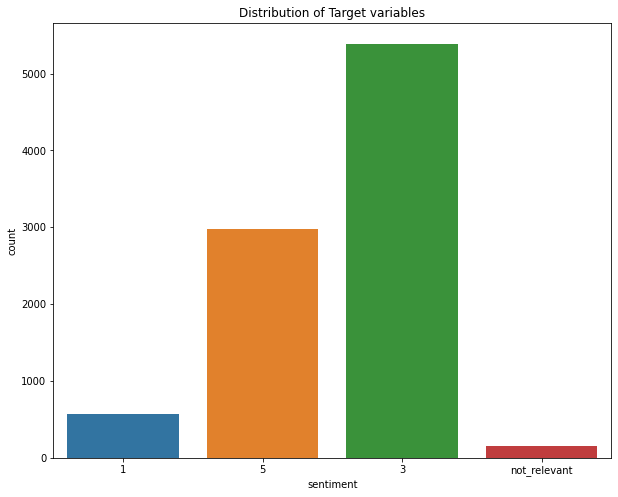

In [13]:
fig, ax = plt.subplots(figsize=(10,8))
ax = sns.countplot(data=data,x='sentiment')
ax.set(title='Distribution of Target variables');
# ax.set(title='Distribution of Target variables',xticklabels=['Neutral','Positive','Negative','not_relevant']); # remove not_relevant

### Most common words

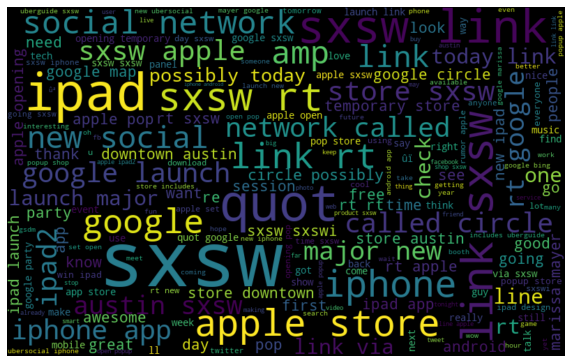

In [14]:
# from wordcloud import WordCloud 
# plt.figure(figsize = (20,20))
# wc = WordCloud(max_words = 1000 , width = 1600 , height = 800,
#                collocations=False, font_path="arial.ttf").generate(" ".join(data['cleaned_text']))
# plt.imshow(wc)
all_words = ' '.join(data['cleaned_text']) ##Convert word list to a single string

#generating the wordcloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words)
#plot the wordcloud
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

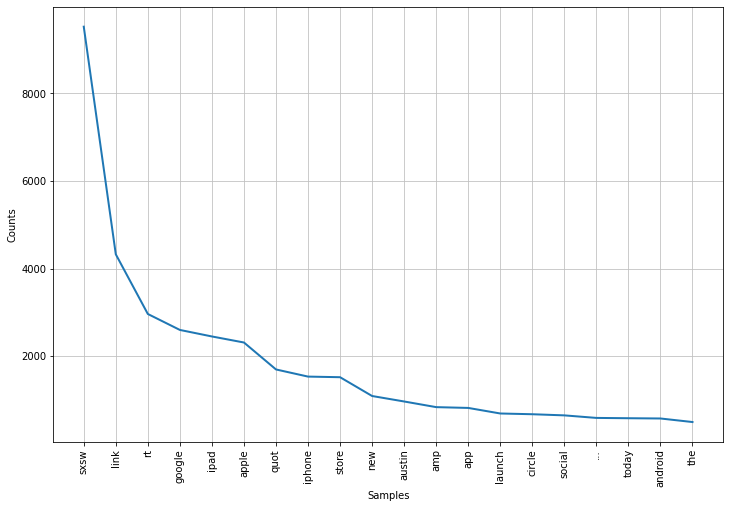

In [15]:
#find the frequency of words
textdata = ' '.join(data['cleaned_text']) #combine all rows into a single text
tokens = word_tokenize(textdata) #tokenize data

fig, ax = plt.subplots(figsize=(12,8))
#Find frequency distribution
ax.fdist =FreqDist(tokens) 

#Plot the 10 most common words
ax.fdist.plot(20)
plt.show()

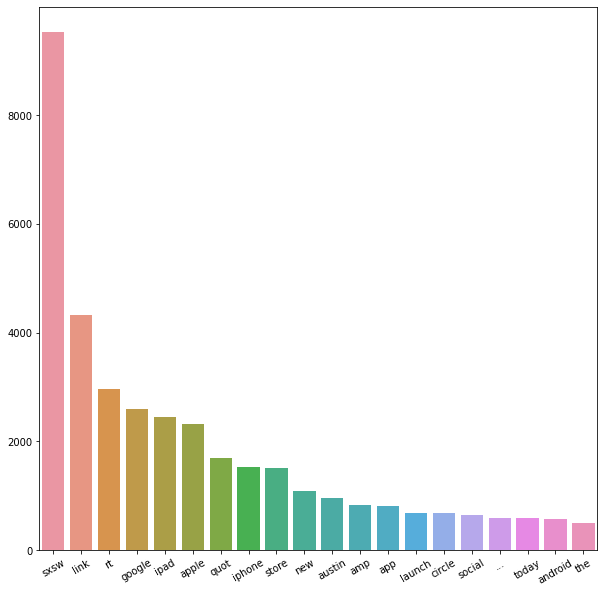

In [16]:
## Creating FreqDist for whole BoW, keeping the 20 most common tokens
all_fdist = FreqDist(tokens).most_common(20)

## Conversion to Pandas series via Python Dictionary for easier plotting
all_fdist = pd.Series(dict(all_fdist))

## Setting figure, ax into variables
fig, ax = plt.subplots(figsize=(10,10))

## Seaborn plotting using Pandas attributes + xtick rotation for ease of viewing
all_plot = sns.barplot(x=all_fdist.index, y=all_fdist.values, ax=ax)
plt.xticks(rotation=30);

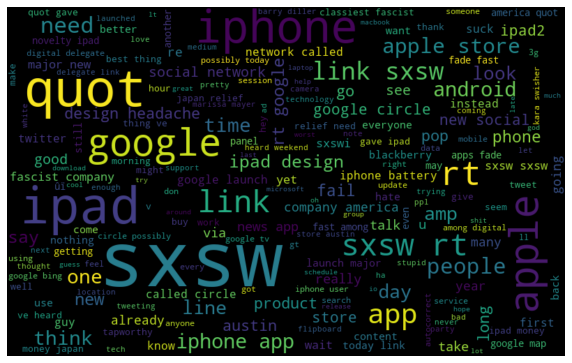

In [17]:
#Negative words
negative_words = ' '.join(data.query("sentiment=='1'")['cleaned_text'])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(negative_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

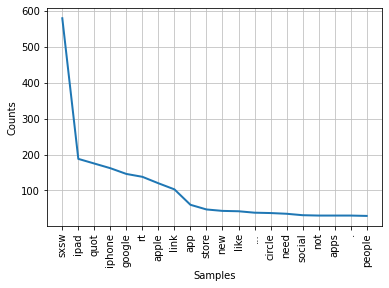

{('.', 30),
 ('...', 38),
 ('app', 60),
 ('apple', 120),
 ('apps', 30),
 ('circle', 37),
 ('google', 146),
 ('ipad', 188),
 ('iphone', 162),
 ('like', 42),
 ('link', 103),
 ('need', 35),
 ('new', 43),
 ('not', 30),
 ('people', 29),
 ('quot', 175),
 ('rt', 138),
 ('social', 31),
 ('store', 47),
 ('sxsw', 580)}

In [18]:
negative_tokens = word_tokenize(negative_words) #tokenize data

#Find frequency distribution
fdist =FreqDist(negative_tokens) 

#Plot the 10 most common words
fdist.plot(20)
plt.show()
set(fdist.most_common(20))

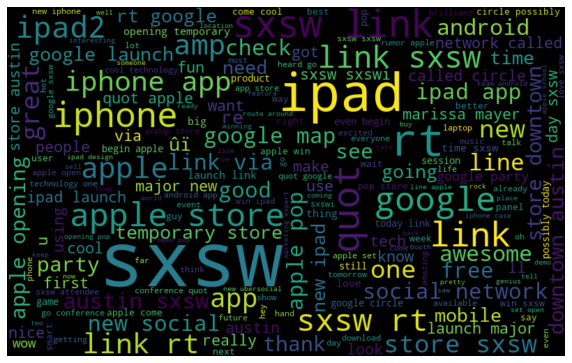

In [19]:
#positive words
positive_words = ' '.join(data.query("sentiment=='5'")['cleaned_text'])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(positive_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

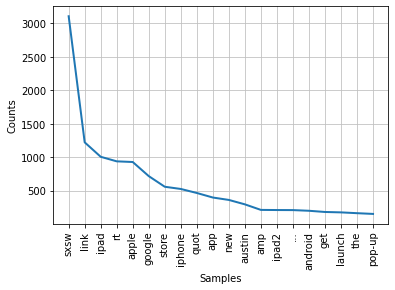

In [20]:
tokens = word_tokenize(positive_words) #tokenize data

#Find frequency distribution
fdist =FreqDist(tokens) 

#Plot the 10 most common words
fdist.plot(20)
plt.show()

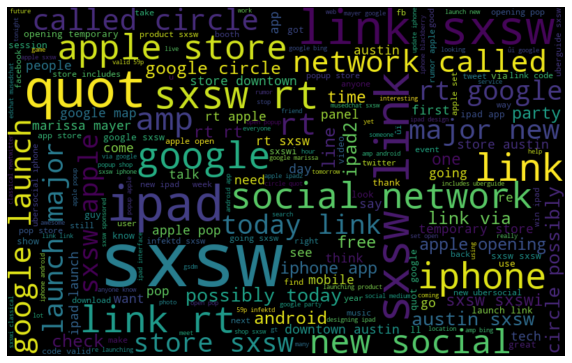

In [21]:
#neutral
neutral_words = ' '.join(data.query("sentiment=='3'")['cleaned_text'])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neutral_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

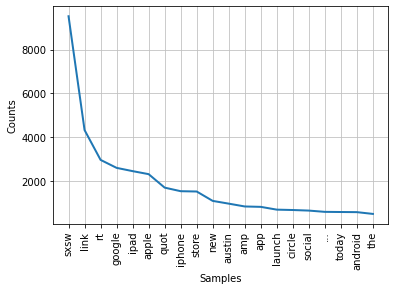

In [22]:
tokens = word_tokenize(all_words) #tokenize data

#Find frequency distribution
fdist =FreqDist(tokens) 

#Plot the 20 most common words
fdist.plot(20)
plt.show()

In [23]:
import pandas as pd
import nltk
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

# Ensure NLTK is ready
nltk.download('punkt')

# Assuming `data` is a Pandas DataFrame with 'cleaned_text' and 'sentiment' columns
pos_texts = data.query("sentiment=='5'")['cleaned_text'].tolist()
neg_texts = data.query("sentiment=='1'")['cleaned_text'].tolist()

# Tokenize words for each sentiment
positive_words = [word for text in pos_texts for word in word_tokenize(text.lower())]
negative_words = [word for text in neg_texts for word in word_tokenize(text.lower())]

# Compute frequency distributions
fdist_pos = FreqDist(positive_words)
fdist_neg = FreqDist(negative_words)

# Find common words appearing in both sentiment groups
common_words = set(fdist_pos.keys()).intersection(set(fdist_neg.keys()))

# Function to remove common words from text
def remove_common_words(text):
    words = word_tokenize(text.lower())
    filtered_words = [word for word in words if word not in common_words]
    return " ".join(filtered_words)

# Apply the function to remove common words from both sentiment groups
data['filtered_text'] = data['cleaned_text'].apply(remove_common_words)

# Display updated DataFrame
data[['sentiment', 'cleaned_text', 'filtered_text']].head()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Gmwende\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,sentiment,cleaned_text,filtered_text
0,1,3g iphone after hr tweeting rise_austin dead n...,rise_austin
1,5,know awesome ipad/iphone app 'll likely apprec...,appreciate giving t
2,5,can wait ipad also they sale sxsw,
3,1,hope year festival crashy year iphone app sxsw,crashy
4,5,great stuff fri sxsw marissa mayer google tim ...,fri books/conferences matt


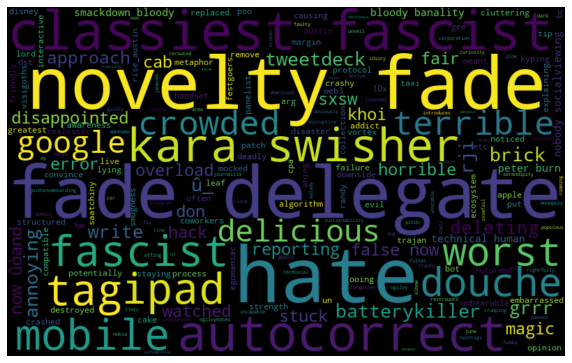

In [24]:
#negative
neutral_words = ' '.join(data.query("sentiment=='1'")['filtered_text'])
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(neutral_words)

plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

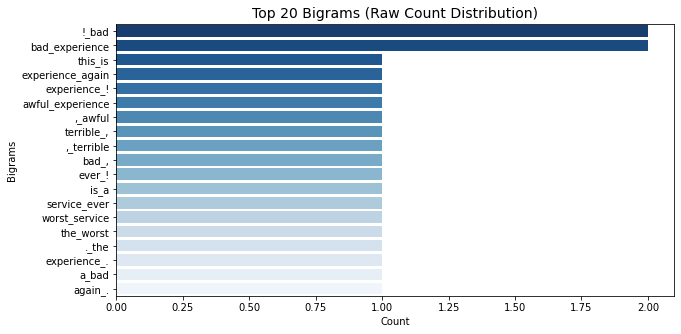

In [25]:
## Imports
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk import bigrams
from nltk.tokenize import word_tokenize

# Sample negative text (Replace with your actual dataset)
negative_text = "This is a bad experience. The worst service ever! Bad, terrible, awful experience! Bad experience again."
negative_tokens = word_tokenize(negative_text.lower())  # Tokenize and lowercase

## Generate bigrams & convert to list
bigram_list = list(bigrams(negative_tokens))

## ✅ FIX: Get raw counts using Pandas
bigram_counts = pd.DataFrame(bigram_list, columns=["Word1", "Word2"])
bigram_counts["Bigram"] = bigram_counts["Word1"] + "_" + bigram_counts["Word2"]  # Join words with '_'
bigram_counts = bigram_counts["Bigram"].value_counts().reset_index()  # Count occurrences

## ✅ Get the top 20 bigrams
bigram_counts.columns = ["Bigram", "Count"]
bigram_counts = bigram_counts.head(20)

## Setting figure & ax for plots
fig, ax = plt.subplots(figsize=(10, 5))

## ✅ FIX: Use raw counts instead of frequencies
sns.barplot(data=bigram_counts, x="Count", y="Bigram", orient="h", ax=ax, palette="Blues_r")

## Set plot title & labels
ax.set_title("Top 20 Bigrams (Raw Count Distribution)", fontsize=14)
ax.set_xlabel("Count")
ax.set_ylabel("Bigrams")

## Show plot
plt.show()


In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9092 entries, 0 to 9092
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   tweet_text                       9092 non-null   object
 1   emotion_in_tweet_is_directed_at  3291 non-null   object
 2   sentiment                        9092 non-null   object
 3   cleaned_text                     9092 non-null   object
 4   filtered_text                    9092 non-null   object
dtypes: object(5)
memory usage: 426.2+ KB


### Modelling

In [27]:
#split data into x and y
X = data['cleaned_text']
y = data['sentiment']

#convert token to a list 
data['joined_preprocessed_text'] = data['cleaned_text'].str.join("")

#split data into a training and test set
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

#create a 'vectorizer' instance
vectorizer = TfidfVectorizer()

#fit the vectorizer to the training data
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

 ### Baseline Logistic Regression model

In [28]:
logreg = LogisticRegression()

#fit to training data
logreg.fit(X_train_tfidf,y_train)

#predict train data
y_hat_train = logreg.predict(X_train_tfidf)
#predict test data
y_hat_test = logreg.predict(X_test_tfidf)

#get accuracy score
base_train_accuracy = accuracy_score(y_train,y_hat_train)
base_test_accuracy = accuracy_score(y_test,y_hat_test)
print(f"Training Accuracy: {base_train_accuracy}")
print(f"Test Accuracy: {base_test_accuracy}")


Training Accuracy: 0.8031112507856694
Test Accuracy: 0.6697214076246334


### Function to fit, predict and evaluate accuracy

In [29]:
def modelling(pipe):
    pipe.fit(X_train,y_train)
    #predict train data
    y_hat_train = pipe.predict(X_train)
    #predict test data
    y_hat_test = pipe.predict(X_test)

    #get accuracy score
    base_train_accuracy = accuracy_score(y_train,y_hat_train)
    base_test_accuracy = accuracy_score(y_test,y_hat_test)
    print(f"Training Accuracy: {base_train_accuracy}")
    print(f"Test Accuracy: {base_test_accuracy}")
    

### Use pipeline

In [30]:
#pipeline to streamline vectorization and model training
pipeline_base = Pipeline([
    ('base_tdif',TfidfVectorizer()),
    ('base_model',LogisticRegression())
])
pipeline_base.fit(X_train,y_train)

#predict train data
y_hat_train = pipeline_base.predict(X_train)
#predict test data
y_hat_test = pipeline_base.predict(X_test)

#get accuracy score
base_train_accuracy = accuracy_score(y_train,y_hat_train)
base_test_accuracy = accuracy_score(y_test,y_hat_test)
print(f"Training Accuracy: {base_train_accuracy}")
print(f"Test Accuracy: {base_test_accuracy}")

Training Accuracy: 0.8031112507856694
Test Accuracy: 0.6697214076246334


In [31]:
#pipeline to streamline vectorization and model training
pipeline_rdf = Pipeline([
    ('base_tdif',TfidfVectorizer()),
     ('smote', SMOTE(random_state=42)),
    ('base_model',RandomForestClassifier(random_state=42))
])
pipeline_rdf.fit(X_train,y_train)

#predict train data
y_hat_train = pipeline_rdf.predict(X_train)
#predict test data
y_hat_test = pipeline_rdf.predict(X_test)

#get accuracy score
base_train_accuracy = accuracy_score(y_train,y_hat_train)
base_test_accuracy = accuracy_score(y_test,y_hat_test)
print(f"Training Accuracy: {base_train_accuracy}")
print(f"Test Accuracy: {base_test_accuracy}")
pipeline_rdf.predict(['fuckoff'])

Training Accuracy: 0.9930861093651792
Test Accuracy: 0.6513929618768328


array(['3'], dtype=object)

In [32]:
def predict_sentiment(review):
    review_preprocessed =clean_text(review)
    print(review_preprocessed)
    prediction = pipeline_rdf.predict([review_preprocessed])
    print('prediction:',prediction)
    return "Negative" if prediction[0] == "1" else "Neutral" if prediction[0]=="3"  else "Positive"

review = "bad product"

print("Prediction:", predict_sentiment(review))
# 1 Negative
# 3 Neutral
# 5 Positive

bad product
prediction: ['3']
Prediction: Neutral


In [33]:
modelling(pipeline_base)

Training Accuracy: 0.8031112507856694
Test Accuracy: 0.6697214076246334


In [34]:
modelling(pipeline_rdf)

Training Accuracy: 0.9930861093651792
Test Accuracy: 0.6513929618768328


In [35]:
pipeline_base.set_params(base_model = RandomForestClassifier(random_state=42) )

Pipeline(steps=[('base_tdif', TfidfVectorizer()),
                ('base_model', RandomForestClassifier(random_state=42))])

In [36]:
modelling(pipeline_base)

Training Accuracy: 0.9930861093651792
Test Accuracy: 0.6543255131964809


In [37]:
pipeline_base.set_params(base_model = DecisionTreeClassifier(random_state=42) )

Pipeline(steps=[('base_tdif', TfidfVectorizer()),
                ('base_model', DecisionTreeClassifier(random_state=42))])

In [38]:
modelling(pipeline_base)

Training Accuracy: 0.9930861093651792
Test Accuracy: 0.593841642228739


In [39]:
pipeline_base.set_params(base_model = MultinomialNB())

Pipeline(steps=[('base_tdif', TfidfVectorizer()),
                ('base_model', MultinomialNB())])

In [40]:
modelling(pipeline_base)

Training Accuracy: 0.7399434318038969
Test Accuracy: 0.6359970674486803


In [41]:
pipeline_base.set_params(base_model = svm.SVC())
modelling(pipeline_base)

Training Accuracy: 0.8882778126964174
Test Accuracy: 0.6777859237536656


In [42]:
### also do roc_auc curve

In [43]:
###smote

In [44]:
pipeline_base

Pipeline(steps=[('base_tdif', TfidfVectorizer()), ('base_model', SVC())])

### Grid search


In [45]:
# grid_search = GridSearchCV(estimator=pipe,
#              param_grid=param_grid,
#              )


In [46]:
#used randomized search cv first for a rough idea since it is faster

In [47]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define the parameter distribution
param_dist = {
    'base_tdif__max_df': np.linspace(0.6, 1.0, 5),
    'base_tdif__min_df': [1, 3, 5],
    'base_tdif__ngram_range': [(1, 1), (1, 2)],
    'base_tdif__stop_words': [None, 'english'],

    'base_model__C': np.logspace(-2, 2, 10),  # Logarithmic scale for C
    'base_model__kernel': ['linear', 'rbf'],
    'base_model__gamma': np.logspace(-3, 1, 5),
}

# Randomized Search (Faster)
random_search = RandomizedSearchCV(pipeline_base, param_dist, n_iter=20, cv=5, scoring='accuracy', n_jobs=-1, verbose=2, random_state=42)
random_search.fit(X_train, y_train)

# Best parameters
print("Best Parameters:", random_search.best_params_)
print("Best Score:", random_search.best_score_)


Fitting 5 folds for each of 20 candidates, totalling 100 fits
Best Parameters: {'base_tdif__stop_words': None, 'base_tdif__ngram_range': (1, 1), 'base_tdif__min_df': 1, 'base_tdif__max_df': 0.8, 'base_model__kernel': 'rbf', 'base_model__gamma': 1.0, 'base_model__C': 1.6681005372000592}
Best Score: 0.677402461377324


In [ ]:
#we will use best parameters of randomized search cv  a baseline
param_grid = {
    'base_tdif__stop_words': [None],  # Keep as found
    'base_tdif__ngram_range': [(1, 1), (1, 2)],  # Try unigrams & bigrams
    'base_tdif__min_df': [1, 2],  # Slightly higher min_df
    'base_tdif__max_df': [0.7, 0.8, 0.9],  # Small range around 0.8
    'base_model__kernel': ['rbf'],  # Keep 'rbf' since it performed best
    'base_model__gamma': [0.8, 1.0, 1.2],  # Tune around 1.0
    'base_model__C': [1.5, 1.67, 1.8],  # Narrow range around 1.67
}

# Fine-tune with GridSearchCV
grid_search = GridSearchCV(pipeline_base, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters after fine-tuning
print("Fine-Tuned Best Parameters:", grid_search.best_params_)
print("Fine-Tuned Best Score:", grid_search.best_score_)

In [ ]:
# Expand C, gamma, and ngram_range while keeping the best values.
param_grid = {
    'base_tdif__ngram_range': [(1, 1), (1, 2),(2,2)],  # Try  bigrams
    'base_tdif__min_df': [1, 2],  # Slightly higher min_df
    'base_tdif__max_df': [0.8, 0.9],  # Small range around 0.8
#     'base_model__kernel': ['rbf'],  # Keep 'rbf' since it performed best
    'base_model__gamma': [0.5, 1.0, 2],  # wide gamma range
    'base_model__C': [0.5, 1.67, 3],  # more range for c
}

# Fine-tune with GridSearchCV
grid_search = GridSearchCV(pipeline_base, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Best parameters after fine-tuning
print("Fine-Tuned Best Parameters:", grid_search.best_params_)
print("Fine-Tuned Best Score:", grid_search.best_score_)

In [ ]:
#Trying Xg boost
from xgboost import XGBClassifier
pipeline_base.set_params(base_model =XGBClassifier() )
modelling(pipeline_base)

In [ ]:
len(data)

In [ ]:
#bert